In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
import numpy as np
from sklearn.metrics import r2_score

%matplotlib inline

т к про временные ряды я еще ничего не знаю, кроме того, что они существуют, взяла статью https://habr.com/ru/post/207160/
и попробовала повторить

In [2]:
file = 'time.xlsx'
df1 = pd.read_excel(file, as_index=False)

In [3]:
df1.index = df1['Дата']
df1 = df1.drop('Дата', 1)

In [4]:
df1.head()

,Значение
Дата,
2014-05-01,0
2014-05-02,10
2014-05-03,0
2014-05-04,0
2014-05-05,0


In [5]:
# считаем средненедельные значения
dfWmean = df1.resample('W', how='mean')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  


In [6]:
dfWmean.head()

,Значение
Дата,
2014-05-04,2.500000
2014-05-11,0.000000
2014-05-18,3.142857
2014-05-25,5.285714
2014-06-01,2.142857


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


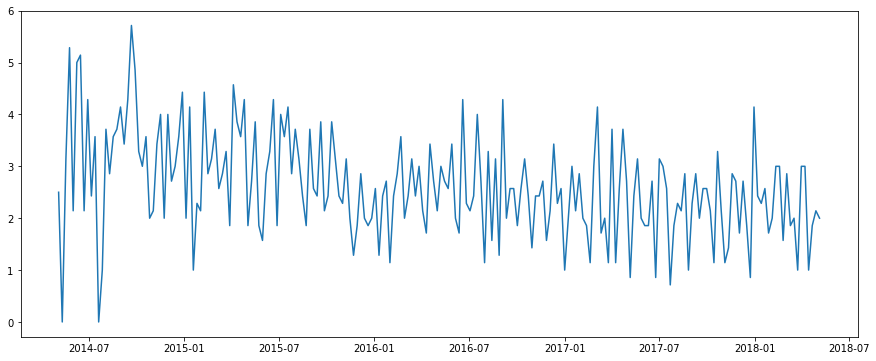

In [7]:
plt.figure(figsize=(15,6))
plt.plot(dfWmean)


,Значение
count,210.000000
mean,2.616667
std,0.991724
min,0.000000
25%,2.000000
50%,2.571429
75%,3.142857
max,5.714286


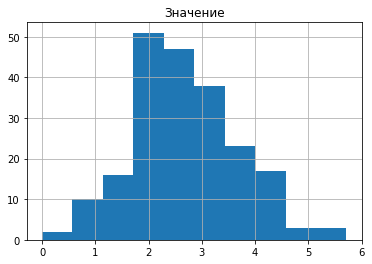

In [8]:
dfmean_stat = dfWmean.describe()
dfWmean.hist()
dfmean_stat

In [9]:
test = sm.tsa.adfuller(dfWmean['Значение'])
print(f'adf: {test[0]}')
print(f'p-value: {test[1]}')
print(f'Critical values: {test[4]}')
if test[0]> test[4]['5%']: 
    print(f'есть единичные корни, ряд не стационарен')
else:
    print(f'единичных корней нет, ряд стационарен')

adf: -1.2095065058066854
p-value: 0.6694929419278736
Critical values: {'1%': -3.464161278384219, '5%': -2.876401960790147, '10%': -2.5746921001665974}
есть единичные корни, ряд не стационарен


In [10]:
row =  ['JB', 'p-value', 'skew', 'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(dfWmean)
a = np.vstack([jb_test]).reshape(1,-1)
itog = SimpleTable(a, row)
itog

JB,p-value,skew,kurtosis
2.9356507056277463,0.23042603605961515,0.27922844829440785,3.1537167279069425


In [11]:
# ряд нормального распределения тк p-value > 0.05

In [12]:
dfmeandiff = dfWmean.diff(periods=1).dropna()

In [13]:
test = sm.tsa.adfuller(dfmeandiff['Значение'])
print(f'adf: {test[0]}')
print(f'p-value: {test[1]}')
print(f'Critical values: {test[4]}')
if test[0]> test[4]['5%']: 
    print(f'есть единичные корни, ряд не стационарен')
else:
    print(f'единичных корней нет, ряд стационарен')


adf: -8.182315332466853
p-value: 8.069498212419196e-13
Critical values: {'1%': -3.464161278384219, '5%': -2.876401960790147, '10%': -2.5746921001665974}
единичных корней нет, ряд стационарен


Высокое p-value дает нам возможность утверждать, что нулевая гипотеза о равенстве средних верна, что свидетельствует о стационарности ряда. Осталось убедиться в отсутствии тренда для этого построим график нашего нового ряда:

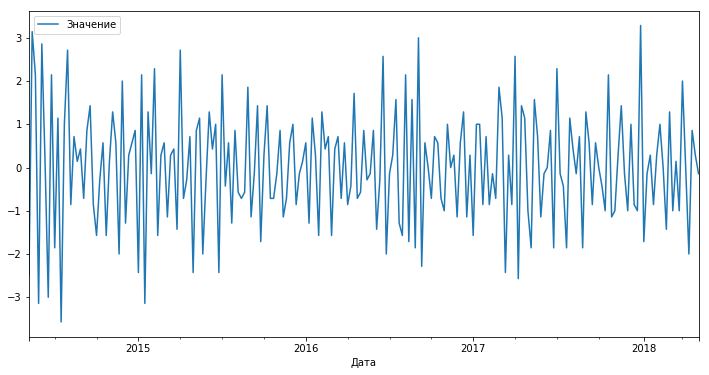

In [14]:
dfmeandiff.plot(figsize=(12,6))

Тренд действительно отсутствует, таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.

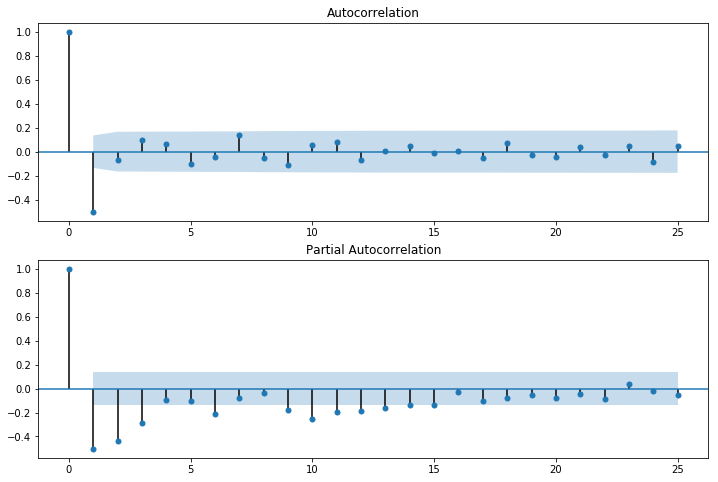

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfmeandiff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfmeandiff, lags=25, ax=ax2)

In [16]:
src_data_model = dfWmean[:'2017-05-26']
model = sm.tsa.ARIMA(src_data_model, order=(1,1,1), freq='W')
mf = model.fit()

In [17]:
print(mf.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Значение   No. Observations:                  159
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -223.032
Method:                       css-mle   S.D. of innovations              0.968
Date:                Thu, 23 May 2019   AIC                            454.065
Time:                        13:21:54   BIC                            466.340
Sample:                    05-11-2014   HQIC                           459.050
                         - 05-21-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0069      0.002     -4.320      0.000      -0.010      -0.004
ar.L1.D.Значение    -0.0312      0.080     -0.392      0.695      -0.187       0.125
ma.L1.D.Значение    -1.0000 

In [18]:
pred = mf.predict('2017-05-28','2018-05-06', typ='levels')
trn = dfWmean['2017-05-26':]

print(f'{pred.shape}')
print(f'{trn.shape}')
r2 = r2_score(trn, pred)
print(f'R^2: {r2:1.2f}')

(50,)
(50, 1)
R^2: -0.07


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


отрицательное значение R^2 означает, что модель работает хуже, чем прямая y=0... так что моделька так себе. но в этом графике не явно заметен тренд.

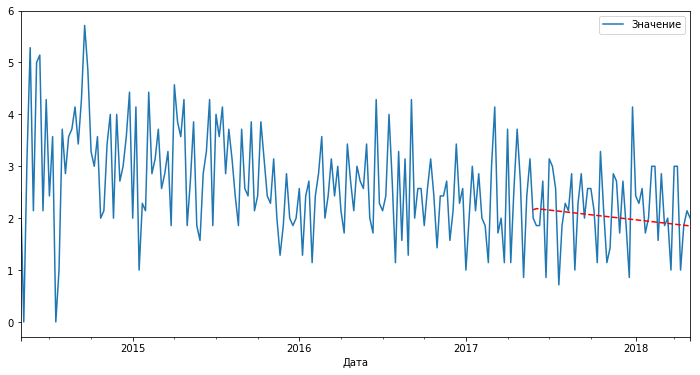

In [19]:
dfWmean.plot(figsize=(12,6))
pred.plot(style='r--')